# Homework 2

Compute Homographies Between Images

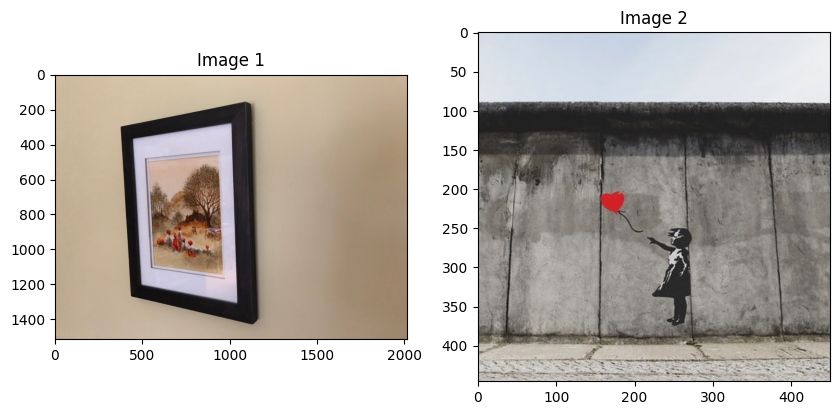

In [20]:

import matplotlib
import matplotlib.pyplot as plt
import cv2
import numpy as np

img1 = cv2.cvtColor(cv2.imread("Images/image1.jpg"), cv2.COLOR_BGR2RGB)
img2 = cv2.cvtColor(cv2.imread("Images/image2.jpg"), cv2.COLOR_BGR2RGB)
f, ax = plt.subplots(1,2,figsize=(10,10))

%matplotlib inline
ax[0].imshow(img1)
ax[0].title.set_text("Image 1")
ax[1].imshow(img2)
ax[1].title.set_text("Image 2")

## Problem 1
Image1 shows a picture on a wall. Our goal is to replace that picture with Image2.
In order to do this we will compute the H matrix that defines the transformation between the two
images and then map image2 in place on image1. 

Several things to consider. You can use the four corner points in each image to setup up the
computation of the H matrix and then map every pixel as needed.

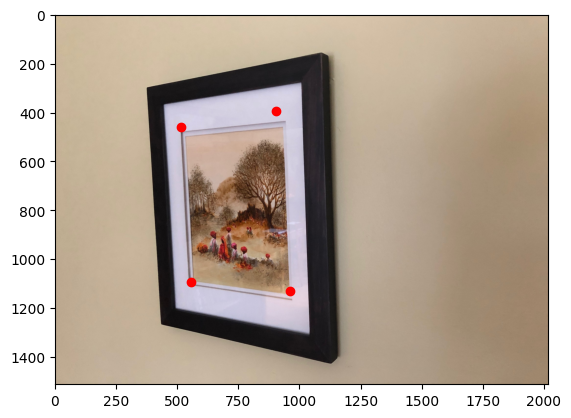

[[ 516  459]
 [ 905  393]
 [ 962 1130]
 [ 557 1093]]
[[  0   0]
 [450   0]
 [450 446]
 [  0 446]]


In [26]:
%matplotlib qt
plt.imshow(img1)
pts_dst = plt.ginput(4)
pts_dst = np.array(pts_dst).astype(int)

plt.scatter(pts_dst[:,0],pts_dst[:,1], c='r')

%matplotlib inline
plt.show()

print(pts_dst)

img2_corners = np.array([[0,0],
                         [img2.shape[1], 0],
                         [img2.shape[1], img2.shape[0]],
                         [0, img2.shape[0]]])
print(img2_corners)

## Problem 2
Given what we learned about homographies and how they warp images can you pick four additional
points from the two images. How would you modify the computation of the H matrix when you have
an over constrained problem (8 points as opposed to 4). Recompute H with these 8 points and comment
on the differences in the H matrix. Map another image (of your own – please keep it PG-13) on image1
with this new homography.

Note 0: Feel free to use a cursor to hand pick the corners in the image
- Feel free to use the matplotlib.pyplot.ginput function

Note 1: Pixel values may not fall on exact integer values. You can use the following call (or something
like it to warp the image).
- #Warp source image to destination based on homography
- im_out = cv2.warpPerspective(im_src, h,(im_dst.shape[1],im_dst.shape[0]))

Note 2: Of course we can do the homography calculation very easily in openCV as well with the
following call (below) but in this homework we want to peek under the hood and figure it out for
ourselves.
- #Calculate Homography
- h, status = cv2.findHomography(pts_src, pts_dst)

# Problem 3
Can you now take multiple images (five?) and stitch them together into a mosaic? 
- Try and stand in a spot and rotate the camera to take multiple overlapping images and then
compute the homographies and map the images onto each other while blending them.
- Please do this for a scene where have a certain distance between yourself and the scene.
- Doing it indoors is going to make it really hard on you. Please do it outside!
- Again we are hand picking four points (or more) common across each image.
- Think about how you would pick the points – collinearity, spacing etc.
- To do a simple blend you can follow the instructions here.
    - https://docs.opencv.org/3.4/d5/dc4/tutorial_adding_images.html
- On the topic of blending check out the classic paper by Burt and Adelson (attached)
And the real imagery that goes with it
    - http://graphics.cs.cmu.edu/courses/15-463/2005_fall/www/Lectures/Pyramids.pdf

In your python notebook write a 4-5 line explanation of how this method differs from the
link above.

Also here is a hint for your panorama: Use the center image as image 0 and map the
homographies from the center outwards. 